## Packages 


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import glob
import nibabel as nib
from skimage.io import imsave
from skimage.transform import resize
from sklearn.preprocessing import normalize
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from skimage.io import imread, imshow
from sklearn.model_selection import train_test_split
from keras.callbacks import  ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
!pip install --upgrade tensorflow
!pip install segmentation_models
import segmentation_models as sm
import cv2
!pip install split-folders
!pip install "tensorflow_hub>=0.6.0"
import tensorflow_hub as tfhub
import statsmodels.api as stats
# !python -m pip install -U efficientnet



Using TensorFlow backend.


Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0)
Segmentation Models: using `keras` framework.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Download The Data 

In [0]:

#Download the dataset
!wget https://zenodo.org/record/3757476/files/COVID-19-CT-Seg_20cases.zip?download=1
!wget https://zenodo.org/record/3757476/files/Lung_and_Infection_Mask.zip?download=1

# Rename the zip files to images and masks, it will be save in the content colab directory 
!mv COVID-19-CT-Seg_20cases.zip?download=1 images.zip
!mv Lung_and_Infection_Mask.zip?download=1 masks.zip

# Extract the two zip files to its nifti files
!unzip -uq "images.zip" -d "images"
!unzip -uq "masks.zip" -d "masks"


# Create temporal Directory 'DataSet' to save the images(png) and masks(png) in google server   
!mkdir DataSet
!mkdir DataSet/images 
!mkdir DataSet/masks


## Load & Preprocess Data

In [0]:
#=================================================================
# Copy DataLoader.py file to temporary colab server to be able to import it 
! cp "drive/My Drive/Project/DataLoader.py" '.'
! cp "drive/My Drive/Project/function.py" '.'
! cp "drive/My Drive/Project/DenseModel.py" '.'




#Import files, Dataloader, DenseModel, function 
from importlib import reload
import DataLoader as ld
from function import *
import DenseModel 
ld = reload(ld)
DenseModel= reload(DenseModel)
# function = reload(function)




In [0]:

# call nifToPng function which extract all the nifti files for images and masks and
# apply preprocessing then save them in DataSet in the temporal google servers 
ld.nifToPng('images','masks');

## Copy Data To Drive.
Data originaly is saved to temporal colab server not drive. 
then by running this code we copy it to drive to store it permenantly, run this process the first time you use the program then start moving it to colab whenever you need it  

In [6]:
# Do this if there is no data in drive 
#!mkdir 'drive/My Drive/Project/DataSet'
# !cp -r 'DataSet/' 'drive/My Drive/Project'

# check number of images and masks  in colab and drive 
print(len(os.listdir('drive/My Drive/Project/DataSet/images')))
print(len(os.listdir('drive/My Drive/Project/DataSet/masks')))
print(len(os.listdir('DataSet/masks')))
print(len(os.listdir('DataSet/images')))


942
1392
3520
3520


## Copy Data From Drive to Temporal colab google server. 
do this step if the temporal session of colab ends and the data is deleted

In [0]:
# when the session ends, all the data on colab server will be deleted. So we get the data from
# the saved dataset in colab.  
# To Copy data from drive to colab it takes som much time so  zip the folder in drive then copy it
# to colab then unzip it 

!cp -r 'drive/My Drive/Project/Dataset.zip' '.'
# unzip the file, change the file name to whatever the zip file name
!unzip -uq "Dataset.zip" -d '.'




## **Train, Test, Validation** 

In [7]:
# Call the splitData function which works on the 
# temporal google server where it is faster 
#! cp "drive/My Drive/Project/DataLoader.py" '.'
X_train, X_tset, Y_train, Y_test, X_, X_val, Y_, Y_val,X = ld.splitData()

100%|██████████| 3520/3520 [00:03<00:00, 1005.86it/s]



Split Done..



##**Fully convolutional multi-scale residual DenseNets**

In [0]:

# Input & output 
IMG_Width  = 128
IMG_Height = 128
IMG_Channels = 1


input=tf.keras.Input((IMG_Width,IMG_Height,IMG_Channels)) # this layer is in core layer of keras documentation
model= DenseModel.dens_model(input)



In [0]:
# # ===============If you want to generate data by batches============================ 
# ! cp "drive/My Drive/Project/DataGenerator.py" '.'
# from importlib import reload
# import DataGenerator as gen
# gen = reload(gen)
# # Split DataSet folder to train, val 
# import split_folders
# split_folders.ratio('DataSet/', output="DataSetGen/", seed=1337, ratio=(.8, .1, .1)) # default values
# # each iteration takes 110 images and masks and pass it to the model(Train) 
# trainGenerator = gen.GenerateBatches('DataSetGen/train', 'images','masks')
# valGenerator = gen.GenerateBatches('DataSetGen/val', 'images','masks')
# # Fit Generator with generator & Augmentation 
# historyGeneratorDense = model.fit_generator(generator=trainGenerator,
#                                             validation_data=valGenerator,
#                                             validation_steps = 100,
#                                             epochs=100,
#                                             steps_per_epoch=100)
# # Save the model 
# model.save('drive/My Drive/Project/FinalDenseAug.h5')
# np.save('drive/My Drive/Project/historyFinalDenseAug.npy',historyGeneratorDense.history)
#==================================================================================
# Fit the Dense Model withoud generator 
Callbacks=[tf.keras.callbacks.ModelCheckpoint("drive/My Drive/Project/dens.h5"
,verbose=1,save_best_only=True)]
 
history = model.fit(
   x=X_train,
   y=Y_train,
   batch_size=16,
   epochs=100,
   validation_data=(X_val, Y_val)
)
 
model.save('drive/My Drive/Project/FinalDenseDice.h5')
 
np.save('drive/My Drive/Project/historyFinalDenseDice.npy',history.history)


## **Build Pretrained Models**

In [0]:
# Copy Model.py file from drive to colab server 
! cp "drive/My Drive/Project/Model.py" '.'

# Import the Model file , we added the reload package to update the changes auto from drive to colab 
from importlib import reload
import Model as mdl
mdl = reload(mdl)

# Buid network, X is the input tensor
mdl.Network(X)




In [0]:
# Fit The pretrained model
history, model = mdl.Fit(X_train, Y_train, X_val, Y_val)


## **Load an existing model & history**
Do this step if you have existing model

In [8]:

# Load PreTrainedModels

# ===========Inception Net v2 , binary ce and Dice loss, IOU metrices====================
inceptionModel = tf.keras.models.load_model('drive/My Drive/Project/Models/inceptionresnetv2.h5',compile=False)
optim = keras.optimizers.Adam(lr=1e-3)

inceptionModel.compile(
    optim,
    loss=sm.losses.bce_dice_loss,
    metrics=[sm.metrics.iou_score],
)   
historyinceptionModel = np.load("drive/My Drive/Project/Models/historyinceptionresnetv2.npy",allow_pickle=True).item()

# ==============Basic u Net , binary ce and Dice loss, IOU metrices=========================
unetModel = tf.keras.models.load_model('drive/My Drive/Project/Models/u_net_basic1.h5',compile=False)
optim = keras.optimizers.Adam(lr=1e-3)

unetModel.compile(
    optim,
    loss=sm.losses.bce_dice_loss,
    metrics=[sm.metrics.iou_score],
)   
historyunetModelModel = np.load("drive/My Drive/Project/Models/historyunet.npy",allow_pickle=True).item()

# ============== densenet201, binary ce and Dice loss, IOU metrices =========================
densenet201Model = tf.keras.models.load_model('drive/My Drive/Project/Models/Densenetb7.h5',compile=False)
optim = keras.optimizers.Adam(lr=1e-3)

densenet201Model.compile(
    optim,
    loss=sm.losses.bce_dice_loss,
    metrics=[sm.metrics.iou_score],
)   
historydensenet201Model = np.load("drive/My Drive/Project/Models/historyDensenetb7.npy",allow_pickle=True).item()



#====================================Main Dense Model===========================================
#========Load Final Dense model,ce loss, Dice coef metrices , optimised with Adam==============
model = tf.keras.models.load_model('drive/My Drive/Project/Models/FinalDense.h5',compile=False)
optim = keras.optimizers.Adam(lr=1e-3)

    
loss= tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0,
    reduction="auto",
    name="categorical_crossentropy",
)


#model.compile(optim,loss=dice_loss ,metrics=[sm.metrics.f1_score]) dice loss 
model.compile(optim,loss=loss ,metrics=[sm.metrics.f1_score])
model.summary()

#History
history = np.load("drive/My Drive/Project/Models/historyFinalDense.npy",allow_pickle=True).item()

# # Plot the model graph
# tf.keras.utils.plot_model(
#     model,
#     to_file="drive/My Drive/Project/Models/model.png",
#     show_shapes=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
#)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 12) 108         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 12) 300         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 12) 588         input_3[0][0]                    
______________________________________________________________________________________________

## **Metrices**


{'loss': [0.02529306523501873, 0.024661840870976448, 0.023453081026673317, 0.02387257292866707, 0.022880012169480324, 0.02175295352935791, 0.021329941228032112, 0.020206637680530548, 0.020198596641421318, 0.01992981508374214, 0.01946214586496353, 0.019244734197854996, 0.01825682260096073, 0.018080413341522217, 0.018513627350330353, 0.017623892053961754, 0.017250128090381622, 0.016868412494659424, 0.016474071890115738, 0.017015600576996803, 0.016299493610858917, 0.01668645441532135, 0.01580459624528885, 0.016274919733405113, 0.01610506884753704, 0.015203336253762245, 0.015295019373297691, 0.014944732189178467, 0.014489922672510147, 0.014720060862600803, 0.014813151210546494, 0.014590919949114323, 0.014328890480101109, 0.013975429348647594, 0.014021876268088818, 0.013698718510568142, 0.013650786131620407, 0.014753648079931736, 0.013650882057845592, 0.01338555570691824, 0.013162652030587196, 0.01291178073734045, 0.013639750890433788, 0.01361332181841135, 0.012978150509297848, 0.0126133533

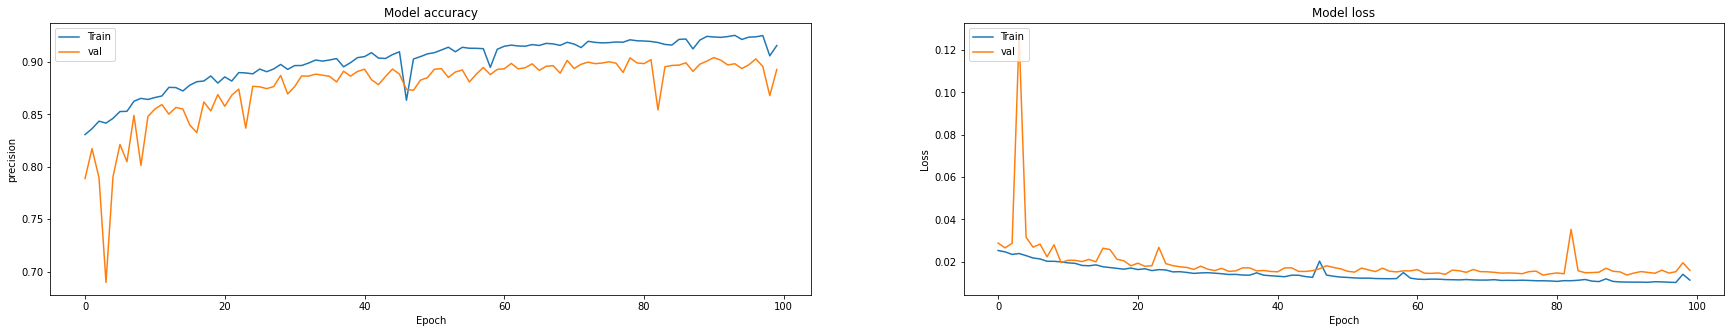

In [9]:

! cp "drive/My Drive/Project/Metrices.py" '.'

from importlib import reload
import Metrices as met
met = reload(met)
print(history )
# Plot Accuracy & Loss DICE(F1 score) 
met.showLossAccu(history)



## **Predictions**

In [19]:
#========================= Evaluate ==============================================
# Proposed Dense Model scores
scoreDense =model.evaluate(X_tset,Y_test,batch_size=26)
# Pre Trained Inception scores 
scoreInception =inceptionModel.evaluate(X_tset,Y_test,batch_size=26)
# Pre Trained densenet201 scores 
scoredensenet201 =densenet201Model.evaluate(X_tset,Y_test,batch_size=26)
# basic unet scores 
scoreBasicUnit =unetModel.evaluate(X_tset,Y_test,batch_size=26)

#=======================Find predections==========================================

# ....................Dense model results.........................................
predDense= model.predict(X_tset)
# merge the labels in last axis, then categorize and encode predict to 4 one hot classes, Dense 
pred_merge = np.argmax(predDense, axis = 3) # (352, 128, 128)
from keras.utils.np_utils import to_categorical   
categorizedPredictDesnse = to_categorical(pred_merge, num_classes=4)
test = np.argmax(Y_test, axis = 3)

# ........................Basic Unit..................................................
predBasicUnet= unetModel.predict(X_tset)
# merge the labels in last axis, then categorize and encode predict to 4 one hot classes, Mobile 
pred_merge_unet = np.argmax(predBasicUnet, axis = 3) # (352, 128, 128)
categorizedPredictUnet = to_categorical(pred_merge_unet, num_classes=4)
testBasicUnet = np.argmax(Y_test, axis = 3)

# Pre Trained models
# .......................inception preds...........................................
predInception= inceptionModel.predict(X_tset)
# merge the labels in last axis, then categorize and encode predict to 4 one hot classes, Mobile 
pred_merge_Inception = np.argmax(predInception, axis = 3) # (352, 128, 128)
categorizedPredictInception = to_categorical(pred_merge_Inception, num_classes=4)
testInception = np.argmax(Y_test, axis = 3)

# .......................densenet201 preds...........................................
predDensenet201= densenet201Model.predict(X_tset)
# merge the labels in last axis, then categorize and encode predict to 4 one hot classes, Mobile 
pred_merge_Densenet201 = np.argmax(predDensenet201, axis = 3) # (352, 128, 128)
categorizedPredictDensenet201 = to_categorical(pred_merge_Densenet201, num_classes=4)
testDensenet201 = np.argmax(Y_test, axis = 3)



14/14 [==============================] - 1s 60ms/step - loss: 0.7002 - iou_score: 0.3283


## **Metrices** 

##Fully convolutional Multi_scale Residual DenseNEt
[link text](https://)

In [28]:
# ======================= Metrices & Statistics====================================

# Dice Cof each class, Dense  
diceCovid = met.dice_coef(Y_test[:,:,:,3],categorizedPredictDesnse[:,:,:,3])
diceLungL = met.dice_coef(Y_test[:,:,:,2],categorizedPredictDesnse[:,:,:,2])
diceLungR = met.dice_coef(Y_test[:,:,:,1],categorizedPredictDesnse[:,:,:,1])
#..................................................................................
# Jaccard(IOU) each class, Dense 
iouDense = met.jc(Y_test,categorizedPredictDesnse)
jcCovid = met.jc(Y_test[:,:,:,3],categorizedPredictDesnse[:,:,:,3])
jcLungL = met.jc(Y_test[:,:,:,2],categorizedPredictDesnse[:,:,:,2])
jcLungR = met.jc(Y_test[:,:,:,1],categorizedPredictDesnse[:,:,:,1])
#...................................................................................
# Hausdorff Distance, Dense 
# hdDense = met.Hausdorff(Y_test,categorizedPredictDesnse)
# HausdorffCovid = met.Hausdorff(Y_test[:,:,:,3],categorizedPredictDesnse[:,:,:,3])
# HausdorffLungL = met.Hausdorff(Y_test[:,:,:,2],categorizedPredictDesnse[:,:,:,2])
# HausdorffLungR = met.Hausdorff(Y_test[:,:,:,1],categorizedPredictDesnse[:,:,:,1])
from scipy.spatial.distance import directed_hausdorff
hdDense = met.Hausdorff(Y_test,categorizedPredictDesnse)
HausdorffCovid = directed_hausdorff(Y_test[90,:,:,3],categorizedPredictDesnse[90,:,:,3])[0]
HausdorffLungL = directed_hausdorff(Y_test[90,:,:,2],categorizedPredictDesnse[90,:,:,2])[0]
HausdorffLungR = directed_hausdorff(Y_test[90,:,:,1],categorizedPredictDesnse[90,:,:,1])[0]

# .................Show analysis results for Dense model(Table).............................. 
import pandas as pd    
data = {'Dice':[scoreDense[1],diceLungL,diceLungR, diceCovid],
        'Jaccard(iou)':[iouDense*100,jcLungL*100,jcLungR*100, jcCovid*100],
        'HD':[hdDense, HausdorffLungL,HausdorffLungR ,HausdorffCovid],
        # 'Pearsona':[pDense[0], pMobile[0], pIncep[0]], 
        # 'P-value':[pDense[1], pMobile[1], pIncep[1]],
        'LR':[0.001, 0.001, 0.001,0.001],
        'Optimizer':['Adam', 'Adam', 'Adam','Adam'],
        'Actiation':['Softmax', 'Softmax', 'Softmax','Softmax'],
        'Param':[model.count_params(),model.count_params(), model.count_params(),model.count_params() ]} 

# Create the pandas DataFrame 
df = pd.DataFrame(data,index =['All classes','Left Lung', 'Right Lung', 'Covid']) 
df 
# .............................ROC & Bland Altman..................................................

#===========================ROC Plots=============================================
met.ROC(Y_test[90,:,:,1].ravel(), categorizedPredictDesnse[90,:,:,1].ravel())
met.ROC(Y_test[90,:,:,2].ravel(), categorizedPredictDesnse[90,:,:,2].ravel())
met.ROC(Y_test[90,:,:,3].ravel(), categorizedPredictDesnse[90,:,:,3].ravel())

# ==========================Bland Altman===========================================
# find surface area 
testPoints = []
for i in range(Y_test.shape[0]):
  for j in range(Y_test.shape[3]):
    pointX = np.count_nonzero(Y_test[i,:,:,j]) / (Y_test.shape[1] * Y_test.shape[2])
    pointY = np.count_nonzero(categorizedPredictDesnse[i,:,:,j]) /(categorizedPredictDesnse.shape[1] * X_tset.shape[2]) 
    testPoints.append([pointX,pointY])
blandAltmanPoints = np.array(testPoints) 
import matplotlib.pyplot as plt
import numpy as np
stats.graphics.mean_diff_plot(blandAltmanPoints[:,0], blandAltmanPoints[:,1])


,Dice,Jaccard(iou),HD,LR,Optimizer,Actiation,Param
All classes,0.918130,98.893101,2.000000,0.001,Adam,Softmax,880500
Left Lung,0.962835,92.833336,2.236068,0.001,Adam,Softmax,880500
Right Lung,0.949259,90.341817,2.000000,0.001,Adam,Softmax,880500
Covid,0.863186,75.930221,1.000000,0.001,Adam,Softmax,880500


Basic Unet model metrices 


In [29]:

# Dice Coef, Basic unet  
basicUnetDice = met.dice_coef(Y_test,categorizedPredictUnet)
basicUnetDiceCovid = met.dice_coef(Y_test[:,:,:,3],categorizedPredictUnet[:,:,:,3])
basicUnetDiceL = met.dice_coef(Y_test[:,:,:,2],categorizedPredictUnet[:,:,:,2])
basicUnetDiceR = met.dice_coef(Y_test[:,:,:,1],categorizedPredictUnet[:,:,:,1])
#.........................................................................................
# Jaccard(IOU) each class, Inception 
basicUnetJcCovid = met.jc(Y_test[:,:,:,3],categorizedPredictUnet[:,:,:,3])
basicUnetJcLungL = met.jc(Y_test[:,:,:,2],categorizedPredictUnet[:,:,:,2])
basicUnetJcLungR = met.jc(Y_test[:,:,:,1],categorizedPredictUnet[:,:,:,1])
#...........................................................................................
# Hausdorff, Inception 
hdbasicUnet = met.Hausdorff(Y_test,categorizedPredictInception)
basicUnetHausdorffCovid = directed_hausdorff(Y_test[90,:,:,3],categorizedPredictUnet[90,:,:,3])[0]
basicUnetHausdorffLungL = directed_hausdorff(Y_test[90,:,:,2],categorizedPredictUnet[90,:,:,2])[0]
basicUnetHausdorffLungR = directed_hausdorff(Y_test[90,:,:,1],categorizedPredictUnet[90,:,:,1])[0]


# ......................Show Analysis results for Inception model...........................    
data = {'Dice':[basicUnetDice,basicUnetDiceCovid,basicUnetDiceL, basicUnetDiceR],
        'Jaccard(iou)':[scoreInception[0],basicUnetJcCovid,basicUnetJcLungL, basicUnetJcLungR],
        'HD':[hdbasicUnet, basicUnetHausdorffCovid,basicUnetHausdorffLungL ,basicUnetHausdorffLungR],
        # 'Pearsona':[pDense[0], pMobile[0], pIncep[0]], 
        # 'P-value':[pDense[1], pMobile[1], pIncep[1]],
        'LR':[0.001, 0.001, 0.001,0.001],
        'Optimizer':['Adam', 'Adam', 'Adam','Adam'],
        'Actiation':['Softmax', 'Softmax', 'Softmax','Softmax'],
        'Param':[unetModel.count_params(),unetModel.count_params(), unetModel.count_params(),unetModel.count_params() ]} 
# Create the pandas DataFrame 
df = pd.DataFrame(data,index =['All classes','Left Lung', 'Right Lung', 'Covid']) 
df 

,Dice,Jaccard(iou),HD,LR,Optimizer,Actiation,Param
All classes,0.888614,0.375948,3.000000,0.001,Adam,Softmax,27550158
Left Lung,0.046544,0.023826,2.236068,0.001,Adam,Softmax,27550158
Right Lung,0.035089,0.017858,6.557439,0.001,Adam,Softmax,27550158
Covid,0.096606,0.050754,4.795832,0.001,Adam,Softmax,27550158


Pre trained Inception Metrices

In [37]:

# Dice Coef, Inception 
inceptionDice = met.dice_coef(Y_test,categorizedPredictInception)
inceptionDiceCovid = met.dice_coef(Y_test[:,:,:,3],categorizedPredictInception[:,:,:,3])
inceptionDiceL = met.dice_coef(Y_test[:,:,:,2],categorizedPredictInception[:,:,:,2])
inceptionDiceR = met.dice_coef(Y_test[:,:,:,1],categorizedPredictInception[:,:,:,1])
#.........................................................................................
# Jaccard(IOU) each class, Inception 
inceptionJcCovid = met.jc(Y_test[:,:,:,3],categorizedPredictInception[:,:,:,3])
inceptionJcLungL = met.jc(Y_test[:,:,:,2],categorizedPredictInception[:,:,:,2])
inceptionJcLungR = met.jc(Y_test[:,:,:,1],categorizedPredictInception[:,:,:,1])
#...........................................................................................
# Hausdorff, Inception 
hdInception = met.Hausdorff(Y_test,categorizedPredictInception)
inceptionHausdorffCovid = directed_hausdorff(Y_test[90,:,:,3],categorizedPredictInception[90,:,:,3])[0]
inceptionHausdorffLungL = directed_hausdorff(Y_test[90,:,:,2],categorizedPredictInception[90,:,:,2])[0]
inceptionHausdorffLungR = directed_hausdorff(Y_test[90,:,:,1],categorizedPredictInception[90,:,:,1])[0]


# ......................Show Analysis results for Inception model...........................    
data = {'Dice':[inceptionDice,inceptionDiceCovid,inceptionDiceL, inceptionDiceR],
        'Jaccard(iou)':[scoreInception[0],inceptionJcCovid,inceptionJcLungL, inceptionJcLungR],
        'HD':[hdInception, inceptionHausdorffCovid,inceptionHausdorffLungL ,inceptionHausdorffLungR],
        # 'Pearsona':[pDense[0], pMobile[0], pIncep[0]], 
        # 'P-value':[pDense[1], pMobile[1], pIncep[1]],
        'LR':[0.00001, 0.00001, 0.00001,0.00001],
        'Optimizer':['Adam', 'Adam', 'Adam','Adam'],
        'Actiation':['Softmax', 'Softmax', 'Softmax','Softmax'],
        'Param':[inceptionModel.count_params(),inceptionModel.count_params(), inceptionModel.count_params(),inceptionModel.count_params() ]} 
# Create the pandas DataFrame 
df = pd.DataFrame(data,index =['All classes','Left Lung', 'Right Lung', 'Covid']) 
df 


,Dice,Jaccard(iou),HD,LR,Optimizer,Actiation,Param
All classes,0.977809,0.375948,3.000000,0.00001,Adam,Softmax,62061994
Left Lung,0.565636,0.394346,1.732051,0.00001,Adam,Softmax,62061994
Right Lung,0.904138,0.825048,2.645751,0.00001,Adam,Softmax,62061994
Covid,0.843148,0.728829,2.645751,0.00001,Adam,Softmax,62061994


In [0]:
Pre trained densenet201 metrices 

In [0]:
# Dice Coef, densenet201 
densenet201Dice = met.dice_coef(Y_test,categorizedPredictDensenet201)
densenet201DiceCovid = met.dice_coef(Y_test[:,:,:,3],categorizedPredictDensenet201[:,:,:,3])
densenet201DiceL = met.dice_coef(Y_test[:,:,:,2],categorizedPredictDensenet201[:,:,:,2])
densenet201DiceR = met.dice_coef(Y_test[:,:,:,1],categorizedPredictDensenet201[:,:,:,1])
#.........................................................................................
# Jaccard(IOU) each class, densenet201 
densenet201JcCovid = met.jc(Y_test[:,:,:,3],categorizedPredictDensenet201[:,:,:,3])
densenet201JcLungL = met.jc(Y_test[:,:,:,2],categorizedPredictDensenet201[:,:,:,2])
densenet201JcLungR = met.jc(Y_test[:,:,:,1],categorizedPredictDensenet201[:,:,:,1])
#...........................................................................................
# Hausdorff, densenet201 
hddensenet201 = met.Hausdorff(Y_test,categorizedPredictDensenet201)
densenet201HausdorffCovid = directed_hausdorff(Y_test[90,:,:,3],categorizedPredictDensenet201[90,:,:,3])[0]
densenet201HausdorffLungL = directed_hausdorff(Y_test[90,:,:,2],categorizedPredictDensenet201[90,:,:,2])[0]
densenet201HausdorffLungR = directed_hausdorff(Y_test[90,:,:,1],categorizedPredictDensenet201[90,:,:,1])[0]


# ......................Show Analysis results for Inception model...........................    
data = {'Dice':[densenet201Dice,densenet201DiceCovid,densenet201DiceL, densenet201DiceR],
        'Jaccard(iou)':[scoredensenet201[0],densenet201JcCovid,densenet201JcLungL, densenet201JcLungR],
        'HD':[hddensenet201, densenet201HausdorffCovid,densenet201HausdorffLungL ,densenet201HausdorffLungR],
        # 'Pearsona':[pDense[0], pMobile[0], pIncep[0]], 
        # 'P-value':[pDense[1], pMobile[1], pIncep[1]],
        'LR':[0.0001, 0.0001, 0.0001,0.0001],
        'Optimizer':['Adam', 'Adam', 'Adam','Adam'],
        'Actiation':['Softmax', 'Softmax', 'Softmax','Softmax'],
        'Param':[densenet201Model.count_params(),densenet201Model.count_params(), densenet201Model.count_params(),densenet201Model.count_params()]} 
# Create the pandas DataFrame 
df = pd.DataFrame(data,index =['All classes','Left Lung', 'Right Lung', 'Covid']) 
df 




Text(0.5, 1.0, 'Covid predicted')

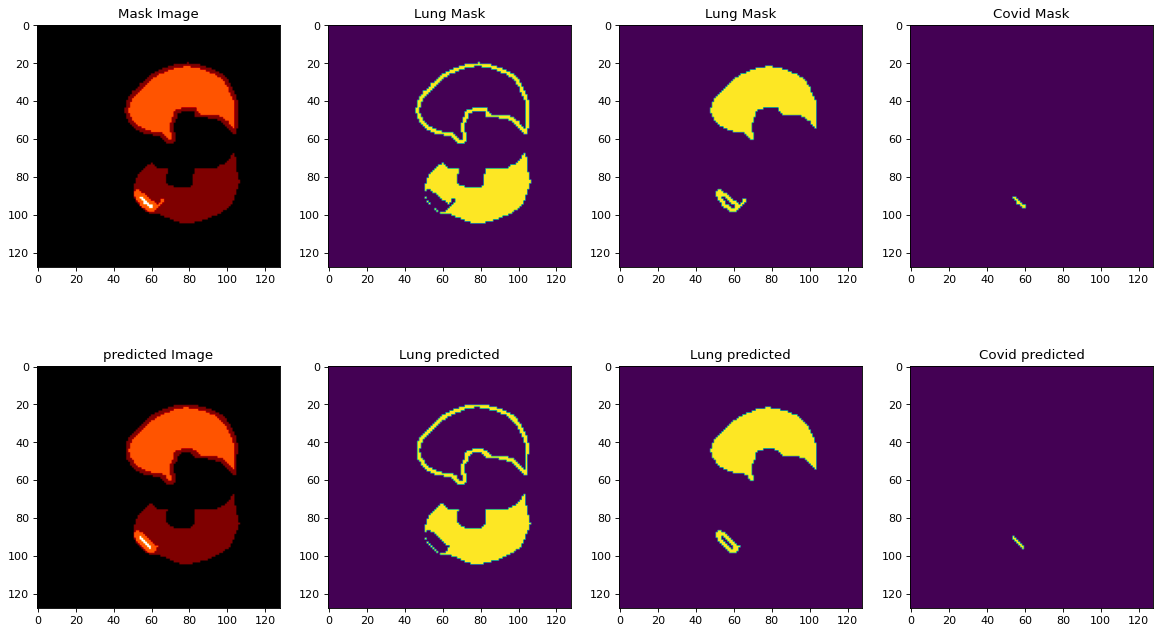

In [35]:

#..................... Plot Results .............................


fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot('341')
plt.imshow(test[77], cmap='gist_heat')
plt.title('Mask Image')
plt.subplot('342')
plt.imshow(Y_test[77,:,:,1])
plt.title('Lung Mask')
plt.subplot('343')
plt.imshow(Y_test[77,:,:,2])
plt.title('Lung Mask')
plt.subplot('344')
plt.imshow(Y_test[77,:,:,3])
plt.title('Covid Mask')
plt.subplot('345')
plt.imshow(pred_merge[77], cmap='gist_heat')
plt.title('predicted Image')
plt.subplot('346')
plt.imshow(categorizedPredictDesnse[77,:,:,1])
plt.title('Lung predicted')
plt.subplot('347')
plt.imshow(categorizedPredictDesnse[77,:,:,2])
plt.title('Lung predicted')
plt.subplot('348')
plt.imshow(categorizedPredictDesnse[77,:,:,3])
plt.title('Covid predicted')



Text(0.5, 1.0, 'Covid predicted')

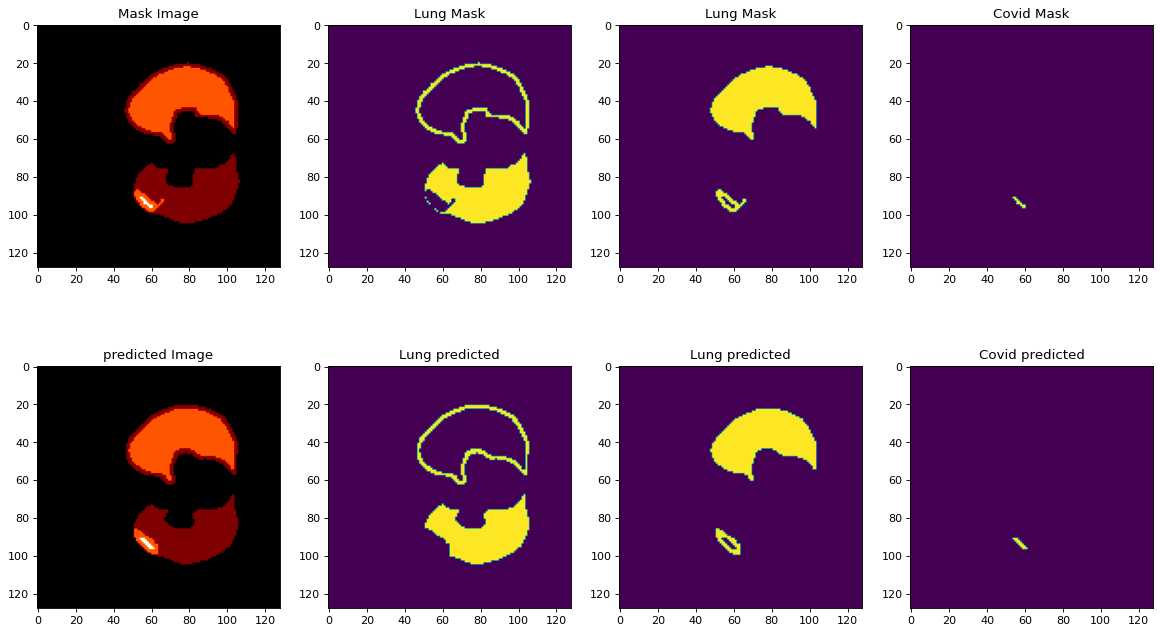

In [34]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot('341')
plt.imshow(test[77], cmap='gist_heat')
plt.title('Mask Image')
plt.subplot('342')
plt.imshow(Y_test[77,:,:,1])
plt.title('Lung Mask')
plt.subplot('343')
plt.imshow(Y_test[77,:,:,2])
plt.title('Lung Mask')
plt.subplot('344')
plt.imshow(Y_test[77,:,:,3])
plt.title('Covid Mask')
plt.subplot('345')
plt.imshow(pred_merge_Densenet201[77], cmap='gist_heat')
plt.title('predicted Image')
plt.subplot('346')
plt.imshow(categorizedPredictDensenet201[77,:,:,1])
plt.title('Lung predicted')
plt.subplot('347')
plt.imshow(categorizedPredictDensenet201[77,:,:,2])
plt.title('Lung predicted')
plt.subplot('348')
plt.imshow(categorizedPredictDensenet201[77,:,:,3])
plt.title('Covid predicted')
 
